# Machine Learning Project

## Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa
import pathlib
import PIL
import os
import time

from PIL import Image as PImage
from PIL import ImageFilter
import random
import math

from datetime import datetime
from packaging import version

import matplotlib.pyplot as plt
import matplotlib
#set fonts to display labels correctly
matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'MS Gothic'
    }
)


AUTOTUNE = tf.data.AUTOTUNE


## Check GPUs

In [2]:
print("GPUs Available: ", tf.test.gpu_device_name())

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.keras.mixed_precision.set_global_policy("mixed_float16")

GPUs Available:  /device:GPU:0
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


In [3]:
tf.config.threading.set_inter_op_parallelism_threads(64)
tf.config.threading.set_intra_op_parallelism_threads(64)

print(tf.config.threading.get_inter_op_parallelism_threads())
print(tf.config.threading.get_intra_op_parallelism_threads())

64
64


## Load Data

Data stored as 201 images per character, each character's images are grouped in folders labelled with the character.

In [4]:

data_dir = pathlib.Path('Data/mnist/')
#data_dir = pathlib.Path('Data/characters/')


image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

'''
low = list(data_dir.glob('低/*'))
for i in range(9):
    PIL.Image.open(str(low[i])) '''

10050


"\nlow = list(data_dir.glob('低/*'))\nfor i in range(9):\n    PIL.Image.open(str(low[i])) "

## Creating the data pipeline

first parameters for loading

In [5]:
batch_size = 64
img_height = 64
img_width = 64
epochs = 20

Split the data into 80% training and 20% testing

In [6]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

for f in list_ds.take(5):
  print(f.numpy())


b'Data\\mnist\\\xe4\xbc\x9a\\\xe4\xbc\x9a_149.png'
b'Data\\mnist\\\xe4\xbc\x91\\\xe4\xbc\x91_031.png'
b'Data\\mnist\\\xe5\x87\xb9\\\xe5\x87\xb9_188.png'
b'Data\\mnist\\\xe5\x89\x8a\\\xe5\x89\x8a_102.png'
b'Data\\mnist\\\xe5\x88\xba\\\xe5\x88\xba_085.png'


In [7]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt']))
print(class_names)

['伎' '伏' '伐' '休' '会' '伝' '伯' '伴' '伶' '伸' '冶' '冷' '凄' '准' '凋' '凌' '凍' '凝'
 '凡' '処' '凧' '凪' '凱' '凶' '凸' '凹' '出' '函' '刀' '刃' '分' '切' '刈' '刊' '刑' '列'
 '初' '判' '別' '利' '到' '制' '刷' '券' '刺' '刻' '剃' '則' '削' '前']


In [8]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

8040
2010


In [9]:
def distort_sample(img):
    """
    Distort the given image randomly.
    Randomly applies the transformations:
        rotation, shear, scale, translate, 
    Randomly applies the filter:
        sharpen, blur, smooth
    Returns the distorted image.
    """

    offset, scale = (0, 0), (64, 64)

    #t = random.choice(["sine", "rotate", "shear", "scale"])
    t = random.choice(["rotate", "shear"])

    f = random.choice(["blur", "sharpen", "smooth"])

    # randomly apply transformations...
    # rotate image
    if("rotate" in t):
        img = tfa.image.transform_ops.rotate(img, random.uniform(-1.0, 1.0) * 3.14159) 
    
    
    # shear image
    if("shear" in t):
        y_shear = random.uniform(-0.2, 0.2)
        x_shear = random.uniform(-0.2, 0.2)
        #img = tfa.image.transform_ops.shear_x(img, x_shear, replace=0)
        #img = tfa.image.transform_ops.shear_y(img, y_shear, replace=0)
    

    return img
    '''
    # scale and translate image
    if("scale" in t):
        #scale the image
        size_x = random.randrange(25, 63)
        size_y = random.randrange(25, 63)
        scale = (size_x, size_y)
        offset = (math.ceil((64 - size_x) / 2), math.ceil((64 - size_y) / 2))
        img = img.resize(scale)

        # put it again on a black background (translated)
        background = PImage.new('L', (64, 64))
        trans_x = random.randrange(0, math.floor((64 - size_x)))
        trans_y = random.randrange(0, math.floor((64 - size_y)))
        offset = (trans_x, trans_y)
        background.paste(img, offset)
        img = background
    
    if("sine" in t):
        t_img = np.array(img)

        A = t_img.shape[0] / 3.0
        w = 2.0 / t_img.shape[1]

        shift_factor = random.choice([-1, 1]) * random.uniform(0.15, 0.2)
        shift = lambda x: shift_factor * A * np.sin(-2*np.pi*x * w)

        for i in range(t_img.shape[0]):
            t_img[:,i] = np.roll(t_img[:,i], int(shift(i)))

        img = PImage.fromarray(t_img)
'''

'''

    # blur
    if("blur" in f):
        img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 1.2)))

    # sharpen
    if("sharpen" in f):
        img = img.filter(ImageFilter.SHARPEN)
        
    # smooth
    if("smooth" in f):
        img = img.filter(ImageFilter.SMOOTH)
'''

    

'\n\n    # blur\n    if("blur" in f):\n        img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 1.2)))\n\n    # sharpen\n    if("sharpen" in f):\n        img = img.filter(ImageFilter.SHARPEN)\n        \n    # smooth\n    if("smooth" in f):\n        img = img.filter(ImageFilter.SMOOTH)\n'

In [10]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # second to last part is class dir
    one_hot = parts[-2] == class_names
    # integer encode the label
    return tf.argmax(one_hot)

In [11]:
def decode_image(img):
    img = tf.io.decode_png(img, channels=1)
    #img = distort_sample(img)
    return tf.image.resize(img, [img_height, img_width])

In [12]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_image(img)
    return img, label

In [13]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [15]:
'''mage_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")
'''

'mage_batch, label_batch = next(iter(train_ds))\n\nplt.figure(figsize=(10, 10))\nfor i in range(9):\n  ax = plt.subplot(3, 3, i + 1)\n  plt.imshow(image_batch[i].numpy().astype("uint8"))\n  label = label_batch[i]\n  plt.title(class_names[label])\n  plt.axis("off")\n'

# Train the model

## Set up model

structures from [2]

In [16]:
from models import *

model = get_M6_2(len(class_names))

#can't have here with the resize layer
#model.summary()

In [17]:
model_dir = './models/'

filepath = os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

log_dir = os.path.join(model_dir, "tf", "logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [checkpoint, tensorboard_callback]

In [18]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=1e-08,)
#learning_rate=0.0001


#optimizer = tf.keras.optimizers.SGD()
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#model.summary()

In [19]:
#model = tf.keras.models.load_model('./models/tf/trained_model/')
#model.load_weights(os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-01-0.00.hdf5"))

In [20]:
'''image_batch, label_batch = next(iter(val_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(f'Actual: {class_names[label]}, Predicted: {model.predict(image_batch[i])}')
  plt.axis("off")'''

'image_batch, label_batch = next(iter(val_ds))\n\nplt.figure(figsize=(10, 10))\nfor i in range(9):\n  ax = plt.subplot(3, 3, i + 1)\n  plt.imshow(image_batch[i].numpy().astype("uint8"))\n  label = label_batch[i]\n  plt.title(f\'Actual: {class_names[label]}, Predicted: {model.predict(image_batch[i])}\')\n  plt.axis("off")'

In [21]:

history = model.fit(
    x=train_ds,
    epochs=epochs,
    initial_epoch=0,
    validation_data=val_ds,
    #callbacks=callbacks_list,
    max_queue_size=400,
    use_multiprocessing=True,
    workers=4)

Epoch 1/5
126/126 [==============================] - 10s 51ms/step - loss: 3.8502 - accuracy: 0.0953 - val_loss: 3.9094 - val_accuracy: 0.0323
Epoch 2/5
126/126 [==============================] - 5s 39ms/step - loss: 3.6388 - accuracy: 0.3101 - val_loss: 3.9074 - val_accuracy: 0.0318
Epoch 3/5
126/126 [==============================] - 5s 39ms/step - loss: 3.5221 - accuracy: 0.4269 - val_loss: 3.9069 - val_accuracy: 0.0343
Epoch 4/5
126/126 [==============================] - 5s 39ms/step - loss: 3.4496 - accuracy: 0.4982 - val_loss: 3.9053 - val_accuracy: 0.0413
Epoch 5/5
126/126 [==============================] - 5s 39ms/step - loss: 3.4042 - accuracy: 0.5446 - val_loss: 3.9047 - val_accuracy: 0.0438


32/32 - 0s - loss: 3.9047 - accuracy: 0.0438
0.0437810942530632


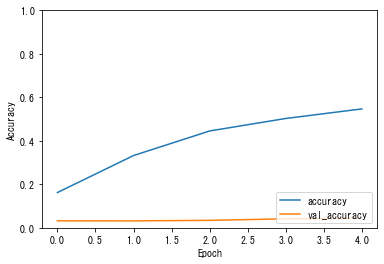

In [22]:


plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x=val_ds, verbose=2)

print(test_acc)

In [23]:
model.save(os.path.join(model_dir, "tf", "trained_model"))

INFO:tensorflow:Assets written to: ./models/tf\trained_model\assets


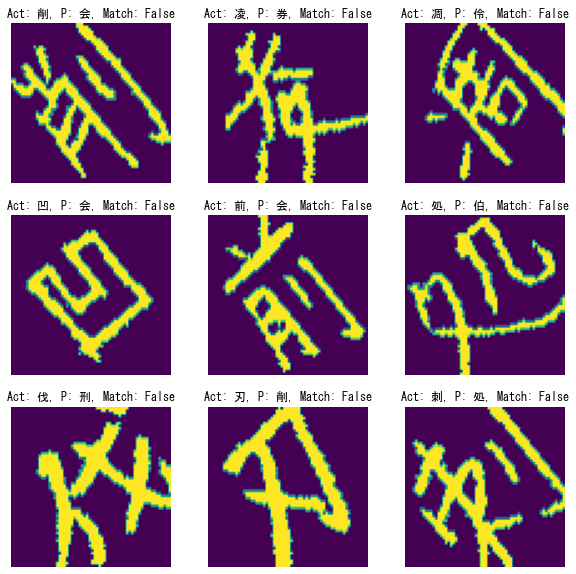

In [24]:
image_batch, label_batch = next(iter(val_ds))
p = model.predict(image_batch)
p = p.argmax(axis=1)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(f'Act: {class_names[label]}, P: {class_names[p[i]]}, Match: {class_names[label] == class_names[p[i]]}')
    plt.axis("off")